# Unsupervised classification with ISO clustering algorithm

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Make-a-Raster-object" data-toc-modified-id="Make-a-Raster-object-1">Make a <code>Raster</code> object</a></span></li><li><span><a href="#Train-ISO-classifier" data-toc-modified-id="Train-ISO-classifier-2">Train ISO classifier</a></span></li></ul></div>

In [1]:
import os
import json

# import arcgis libraries
from arcgis.gis import GIS
from arcgis import raster
from arcgis.features import GeoAccessor
import pandas as pd

# import plotting libs
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
# setup workspace
gis = GIS(profile='your_entp_profile')
gis

Profile your_entp_profile does not have a password on file through keyring. If you are expecting this behavior (PKI or IWA authentication, entering password through run-time prompt, etc.), please ignore this message. If you would like to store your password in the your_entp_profile profile, run GIS(profile = 'your_entp_profile', password = ...). See the API doc for more details. (http://bit.ly/2CK2wG8)


Enter password: ········


GIS @ https://pythonapi.playground.esri.com/portal version:7.1

In [4]:
landsat_item = gis.content.get('bcbe52655d454b829295626afae756f6')
print(landsat_item)

<Item title:"landsat_unsuper_demo" type:Imagery Layer owner:api_data_owner>


In [5]:
landsat_item.layers

[<ImageryLayer url:"https://pythonapi.playground.esri.com/server/rest/services/landsat_unsuper_demo/ImageServer">]

## Make a `Raster` object

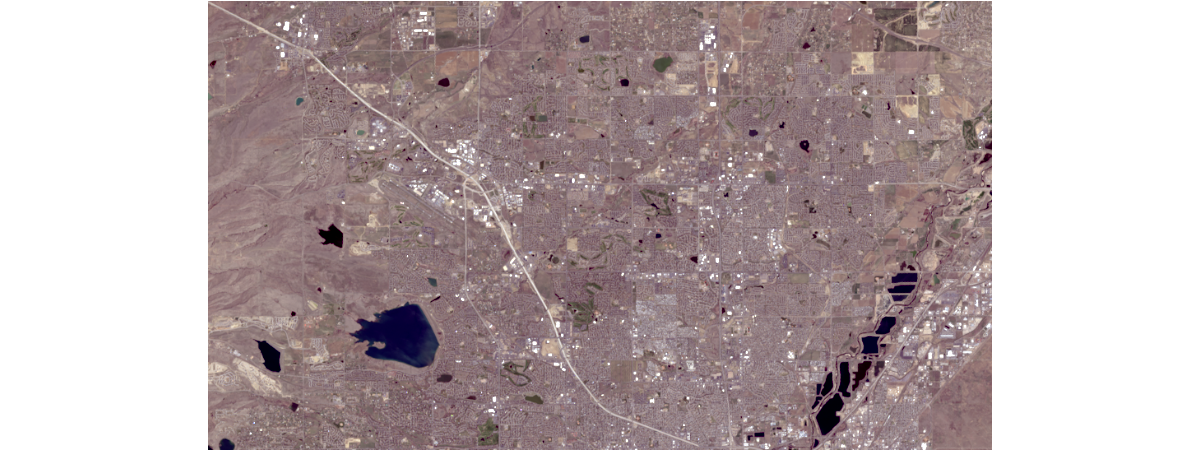

In [7]:
ras1 = raster.Raster(path = landsat_item.layers[0].url)
ras1

In [8]:
ras1.band_count

8

Preview imagery layer on a map

MapView(layout=Layout(height='400px', width='100%'))


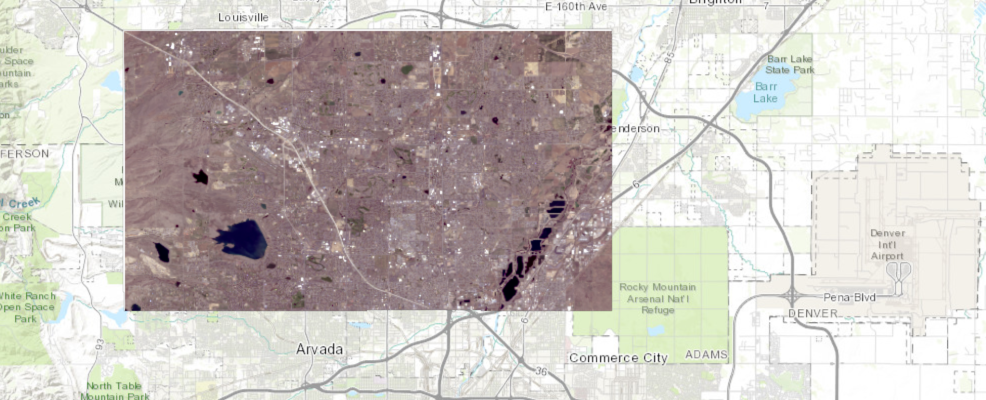

In [16]:
map1 = gis.map('Westminster, CO')
map1

In [17]:
map1.add_layer(ras1)

In [19]:
map1.take_screenshot(False)

## Train ISO classifier

In [20]:
iso_classifier_parameters = {'maxNumClasses':10, "max_iterations":25, 
                             "minNumSamples":100}

In [25]:
%%time
iso_ecs = raster.analytics.train_classifier(input_raster = ras1, 
                                            input_training_sample_json=None, 
                                           classifier_parameters = {'method':'iso',
                                                                   'params':iso_classifier_parameters})

ERROR 000735: inputTrainingSampleJSON: Value is required
Failed.


Exception: Job failed.